## Test des fonctions de reward

In [1]:
"""
import gym


#from cartpole import CartPoleEnv
#env = CartPoleEnv()
env = gym.make('CartPole-v1')
env.reset()
episodes = 20
final = []
for episode in range(episodes):
    state = env.reset()
    done = False
    total = 0
    while not done:
        # Sample random actions
        action = env.action_space.sample()
        # Take action and extract results
        next_state, reward, done, _ = env.step(action)
        # Update reward
        total += reward
        if done:
            break
    # Add to the final reward
    final.append(total)
    print(final)
env.close()
"""

## Test du .render()

In [2]:
"""
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    #env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()
"""

## Discretization du cartpole (sers plus actuellement)

In [3]:
"""""
one_degree = 0.0174532
six_degrees = 0.1047192
twelve_degrees = 0.2094384
fifty_degrees = 0.87266

def get_box(x,x_dot,theta,theta_dot):
  if (x < -0.8): x = 0;
  elif (x < 0.8): x = 1;
  else: x = 2;

  if (x_dot < -0.5): x_dot = 0;
  elif (x_dot < 0.5): x_dot = 1;
  else: x_dot = 2;

  if (theta < -six_degrees): theta = 0
  elif (theta < -one_degree): theta = 1
  elif (theta < 0): theta = 2
  elif (theta < one_degree): theta = 3
  elif (theta < six_degrees): theta = 4
  else: theta = 5

  if (theta_dot < -fifty_degrees): theta_dot = 0;
  elif (theta_dot < fifty_degrees):  box = 1;
  else: box = 2;

  return(box);
"""""

## DQN class et application sur cartpole

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
from collections import deque
import gym
import random

Using TensorFlow backend.


In [2]:

GAMMA = 0.95
LEARNING_RATE = 0.001
MEMORY_SIZE = 1000000
BATCH_SIZE = 20
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.998

class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        
    
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [9]:
def cartpole(EPISODES):
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)

    
    final = []
    for e in range(EPISODES):
        
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        while True:
            step += 1
            #env.render()
            action = dqn_solver.act(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward if not terminal else -reward
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if terminal:
                print("Run: " + str(e) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
                break
            dqn_solver.experience_replay()
        final.append(step)
            
    dqn_solver.save("./cartpole-dqn.h5")
    #print(dqn_solver.model.layers[0].get_weights()[0])
    return final
    

In [42]:
results = cartpole(10)

Run: 0, exploration: 1.0, score: 12
Run: 1, exploration: 0.9801790433519495, score: 18
Run: 2, exploration: 0.9398245380496356, score: 22
Run: 3, exploration: 0.8727237754706968, score: 38
Run: 4, exploration: 0.8486026537619556, score: 15
Run: 5, exploration: 0.7991358687971188, score: 31
Run: 6, exploration: 0.7450571198597635, score: 36
Run: 7, exploration: 0.7215696031781899, score: 17
Run: 8, exploration: 0.684971186740455, score: 27
Run: 9, exploration: 0.6013917789643461, score: 66
[[-0.12076794 -0.19908799  0.07603423 -0.49543872 -0.09274016  0.1370585
   0.7004281   0.07828736 -0.47499463  0.12281825  0.22132458 -0.38151222
  -0.17587084  0.2372544  -0.17899603 -0.11059985 -0.3298313  -0.61834943
  -0.44205296 -0.12091755 -0.6845082  -0.32522842  0.28774393 -0.06576917]
 [-0.37843376 -0.32927975 -0.55105555 -0.0254655   0.36433473 -0.19687702
  -0.3337792  -0.13071582  0.02683747  0.04569326  0.02263121  0.0933734
   0.08291382  0.04233343  0.05198677 -0.3471207  -0.16834657  

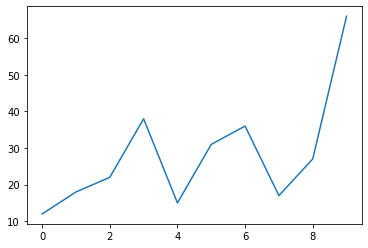

In [61]:
import matplotlib.pyplot as plt
plt.plot(results)
plt.savefig('score.png', bbox_inches='tight')

## Essai réussi de reload l'agent :)

In [3]:
import gym
import time
env = gym.make('CartPole-v0')

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
dqn_solver = DQNSolver(observation_space, action_space)

dqn_solver.load("./cartpole-dqn.h5")
state = env.reset()
state = np.reshape(state, [1, observation_space])

for e in range(800):
    #env.render()
    action = np.argmax(dqn_solver.model.predict(state)[0])
    state_next, reward, terminal, info = env.step(action)
    state_next = np.reshape(state_next, [1, observation_space])
    state = state_next
    #time.sleep(0.5)
    if terminal:
        print("Score atteint ",e)
        print("done")
        break
env.close()


Score atteint  129
done


## Maintenant deep Learning plus compliqué (DDQ avec image input via atari)

In [15]:
"""
import numpy as np
import os
import random
import shutil
from statistics import mean
from game_models.base_game_model import BaseGameModel
from convolutional_neural_network import ConvolutionalNeuralNetwork

GAMMA = 0.99
MEMORY_SIZE = 900000
BATCH_SIZE = 32
TRAINING_FREQUENCY = 4
TARGET_NETWORK_UPDATE_FREQUENCY = 40000
MODEL_PERSISTENCE_UPDATE_FREQUENCY = 10000
REPLAY_START_SIZE = 50000

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_TEST = 0.02
EXPLORATION_STEPS = 850000
EXPLORATION_DECAY = (EXPLORATION_MAX-EXPLORATION_MIN)/EXPLORATION_STEPS


class DDQNGameModel():

    def __init__(self, game_name, mode_name, input_shape, action_space, logger_path, model_path):
        self.action_space = action_space
        self.input_shape = input_shape
        self.model_path = model_path
        self.ddqn = ConvolutionalNeuralNetwork(self.input_shape, action_space).model
        if os.path.isfile(self.model_path):
            self.ddqn.load_weights(self.model_path)

    def _save_model(self):
        self.ddqn.save_weights(self.model_path)


class DDQNSolver(DDQNGameModel):

    def __init__(self, game_name, input_shape, action_space):
        testing_model_path = "./output/neural_nets/" + game_name + "/ddqn/testing/model.h5"
        assert os.path.exists(os.path.dirname(testing_model_path)), "No testing model in: " + str(testing_model_path)
        DDQNGameModel.__init__(self,
                               game_name,
                               "DDQN testing",
                               input_shape,
                               action_space,
                               "./output/logs/" + game_name + "/ddqn/testing/" + self._get_date() + "/",
                               testing_model_path)

    def move(self, state):
        if np.random.rand() < EXPLORATION_TEST:
            return random.randrange(self.action_space)
        q_values = self.ddqn.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0), batch_size=1)
        return np.argmax(q_values[0])


class DDQNTrainer(DDQNGameModel):

    def __init__(self, game_name, input_shape, action_space):
        DDQNGameModel.__init__(self,
                               game_name,
                               "DDQN training",
                               input_shape,
                               action_space,
                               "./output/logs/" + game_name + "/ddqn/training/" + self._get_date() + "/",
                               "./output/neural_nets/" + game_name + "/ddqn/" + self._get_date() + "/model.h5")

        if os.path.exists(os.path.dirname(self.model_path)):
            shutil.rmtree(os.path.dirname(self.model_path), ignore_errors=True)
        os.makedirs(os.path.dirname(self.model_path))

        self.ddqn_target = ConvolutionalNeuralNetwork(self.input_shape, action_space).model
        self._reset_target_network()
        self.epsilon = EXPLORATION_MAX
        self.memory = []

    def move(self, state):
        if np.random.rand() < self.epsilon or len(self.memory) < REPLAY_START_SIZE:
            return random.randrange(self.action_space)
        q_values = self.ddqn.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0), batch_size=1)
        return np.argmax(q_values[0])

    def remember(self, current_state, action, reward, next_state, terminal):
        self.memory.append({"current_state": current_state,
                            "action": action,
                            "reward": reward,
                            "next_state": next_state,
                            "terminal": terminal})
        if len(self.memory) > MEMORY_SIZE:
            self.memory.pop(0)

    def step_update(self, total_step):
        if len(self.memory) < REPLAY_START_SIZE:
            return

        if total_step % TRAINING_FREQUENCY == 0:
            loss, accuracy, average_max_q = self._train()
            self.logger.add_loss(loss)
            self.logger.add_accuracy(accuracy)
            self.logger.add_q(average_max_q)

        self._update_epsilon()

        if total_step % MODEL_PERSISTENCE_UPDATE_FREQUENCY == 0:
            self._save_model()

        if total_step % TARGET_NETWORK_UPDATE_FREQUENCY == 0:
            self._reset_target_network()
            print('{{"metric": "epsilon", "value": {}}}'.format(self.epsilon))
            print('{{"metric": "total_step", "value": {}}}'.format(total_step))

    def _train(self):
        batch = np.asarray(random.sample(self.memory, BATCH_SIZE))
        if len(batch) < BATCH_SIZE:
            return

        current_states = []
        q_values = []
        max_q_values = []

        for entry in batch:
            current_state = np.expand_dims(np.asarray(entry["current_state"]).astype(np.float64), axis=0)
            current_states.append(current_state)
            next_state = np.expand_dims(np.asarray(entry["next_state"]).astype(np.float64), axis=0)
            next_state_prediction = self.ddqn_target.predict(next_state).ravel()
            next_q_value = np.max(next_state_prediction)
            q = list(self.ddqn.predict(current_state)[0])
            if entry["terminal"]:
                q[entry["action"]] = entry["reward"]
            else:
                q[entry["action"]] = entry["reward"] + GAMMA * next_q_value
            q_values.append(q)
            max_q_values.append(np.max(q))

        fit = self.ddqn.fit(np.asarray(current_states).squeeze(),
                            np.asarray(q_values).squeeze(),
                            batch_size=BATCH_SIZE,
                            verbose=0)
        loss = fit.history["loss"][0]
        accuracy = fit.history["acc"][0]
        return loss, accuracy, mean(max_q_values)

    def _update_epsilon(self):
        self.epsilon -= EXPLORATION_DECAY
        self.epsilon = max(EXPLORATION_MIN, self.epsilon)

    def _reset_target_network(self):
        self.ddqn_target.set_weights(self.ddqn.get_weights())
"""

'\nimport numpy as np\nimport os\nimport random\nimport shutil\nfrom statistics import mean\nfrom game_models.base_game_model import BaseGameModel\nfrom convolutional_neural_network import ConvolutionalNeuralNetwork\n\nGAMMA = 0.99\nMEMORY_SIZE = 900000\nBATCH_SIZE = 32\nTRAINING_FREQUENCY = 4\nTARGET_NETWORK_UPDATE_FREQUENCY = 40000\nMODEL_PERSISTENCE_UPDATE_FREQUENCY = 10000\nREPLAY_START_SIZE = 50000\n\nEXPLORATION_MAX = 1.0\nEXPLORATION_MIN = 0.1\nEXPLORATION_TEST = 0.02\nEXPLORATION_STEPS = 850000\nEXPLORATION_DECAY = (EXPLORATION_MAX-EXPLORATION_MIN)/EXPLORATION_STEPS\n\n\nclass DDQNGameModel():\n\n    def __init__(self, game_name, mode_name, input_shape, action_space, logger_path, model_path):\n        self.action_space = action_space\n        self.input_shape = input_shape\n        self.model_path = model_path\n        self.ddqn = ConvolutionalNeuralNetwork(self.input_shape, action_space).model\n        if os.path.isfile(self.model_path):\n            self.ddqn.load_weights(sel

In [18]:
import numpy as np
import os
import random
import shutil
from statistics import mean
from datetime import datetime
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

GAMMA = 0.99
MEMORY_SIZE = 900000
BATCH_SIZE = 32
TRAINING_FREQUENCY = 4
TARGET_NETWORK_UPDATE_FREQUENCY = 40000
MODEL_PERSISTENCE_UPDATE_FREQUENCY = 10000
REPLAY_START_SIZE = 50000

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_TEST = 0.02
EXPLORATION_STEPS = 850000
EXPLORATION_DECAY = (EXPLORATION_MAX-EXPLORATION_MIN)/EXPLORATION_STEPS


class DDQNGameModel():

    def __init__(self, game_name, mode_name, input_shape, action_space, logger_path, model_path):
        self.action_space = action_space
        self.input_shape = input_shape
        self.model_path = model_path
        
        #Section Modele neural network
        self.model = Sequential()
        self.model.add(Conv2D(32,
                              8,
                              strides=(4, 4),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Conv2D(64,
                              4,
                              strides=(2, 2),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Conv2D(64,
                              3,
                              strides=(1, 1),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation="relu"))
        self.model.add(Dense(action_space))
        self.model.compile(loss="mean_squared_error",
                           optimizer=RMSprop(lr=0.00025,
                                             rho=0.95,
                                             epsilon=0.01),
                           metrics=["accuracy"])
        #self.model.summary()
        
        self.ddqn = self.model
        
        
        
        if os.path.isfile(self.model_path):
            self.ddqn.load_weights(self.model_path)

    def _save_model(self):
        self.ddqn.save_weights(self.model_path)


class DDQNSolver(DDQNGameModel):

    def __init__(self, game_name, input_shape, action_space):
        testing_model_path = "./output/neural_nets/" + game_name + "/ddqn/testing/model.h5"
        assert os.path.exists(os.path.dirname(testing_model_path)), "No testing model in: " + str(testing_model_path)
        DDQNGameModel.__init__(self,
                               game_name,
                               "DDQN testing",
                               input_shape,
                               action_space,
                               "./output/logs/" + game_name + "/ddqn/testing/" + str(datetime.now().strftime("%d-%m-%y_$h-$m")) + "/",
                               testing_model_path)

    def move(self, state):
        if np.random.rand() < EXPLORATION_TEST:
            return random.randrange(self.action_space)
        q_values = self.ddqn.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0), batch_size=1)
        return np.argmax(q_values[0])


class DDQNTrainer(DDQNGameModel):

    def __init__(self, game_name, input_shape, action_space):
        DDQNGameModel.__init__(self,
                               game_name,
                               "DDQN training",
                               input_shape,
                               action_space,
                               "./output/logs/" + game_name + "/ddqn/training/" + str(datetime.now().strftime("%d-%m-%y_$h-$m")) + "/",
                               "./output/neural_nets/" + game_name + "/ddqn/" + str(datetime.now().strftime("%d-%m-%y_$h-$m")) + "/model.h5")

        if os.path.exists(os.path.dirname(self.model_path)):
            shutil.rmtree(os.path.dirname(self.model_path), ignore_errors=True)
        os.makedirs(os.path.dirname(self.model_path))

        #Section Modele neural network
        self.model = Sequential()
        self.model.add(Conv2D(32,
                              8,
                              strides=(4, 4),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Conv2D(64,
                              4,
                              strides=(2, 2),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Conv2D(64,
                              3,
                              strides=(1, 1),
                              padding="valid",
                              activation="relu",
                              input_shape=input_shape,
                              data_format="channels_last"))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation="relu"))
        self.model.add(Dense(action_space))
        self.model.compile(loss="mean_squared_error",
                           optimizer=RMSprop(lr=0.00025,
                                             rho=0.95,
                                             epsilon=0.01),
                           metrics=["accuracy"])
        #self.model.summary()
        
        self.ddqn_target = self.model
        self._reset_target_network()
        self.epsilon = EXPLORATION_MAX
        self.memory = []

    def move(self, state):
        if np.random.rand() < self.epsilon or len(self.memory) < REPLAY_START_SIZE:
            return random.randrange(self.action_space)
        q_values = self.ddqn.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0), batch_size=1)
        return np.argmax(q_values[0])

    def remember(self, current_state, action, reward, next_state, terminal):
        self.memory.append({"current_state": current_state,
                            "action": action,
                            "reward": reward,
                            "next_state": next_state,
                            "terminal": terminal})
        if len(self.memory) > MEMORY_SIZE:
            self.memory.pop(0)

    def step_update(self, total_step):
        if len(self.memory) < REPLAY_START_SIZE:
            return

        if total_step % TRAINING_FREQUENCY == 0:
            loss, accuracy, average_max_q = self._train()
            self.logger.add_loss(loss)
            self.logger.add_accuracy(accuracy)
            self.logger.add_q(average_max_q)

        self._update_epsilon()

        if total_step % MODEL_PERSISTENCE_UPDATE_FREQUENCY == 0:
            self._save_model()

        if total_step % TARGET_NETWORK_UPDATE_FREQUENCY == 0:
            self._reset_target_network()
            print('{{"metric": "epsilon", "value": {}}}'.format(self.epsilon))
            print('{{"metric": "total_step", "value": {}}}'.format(total_step))

    def _train(self):
        batch = np.asarray(random.sample(self.memory, BATCH_SIZE))
        if len(batch) < BATCH_SIZE:
            return

        current_states = []
        q_values = []
        max_q_values = []

        for entry in batch:
            current_state = np.expand_dims(np.asarray(entry["current_state"]).astype(np.float64), axis=0)
            current_states.append(current_state)
            next_state = np.expand_dims(np.asarray(entry["next_state"]).astype(np.float64), axis=0)
            next_state_prediction = self.ddqn_target.predict(next_state).ravel()
            next_q_value = np.max(next_state_prediction)
            q = list(self.ddqn.predict(current_state)[0])
            if entry["terminal"]:
                q[entry["action"]] = entry["reward"]
            else:
                q[entry["action"]] = entry["reward"] + GAMMA * next_q_value
            q_values.append(q)
            max_q_values.append(np.max(q))

        fit = self.ddqn.fit(np.asarray(current_states).squeeze(),
                            np.asarray(q_values).squeeze(),
                            batch_size=BATCH_SIZE,
                            verbose=0)
        loss = fit.history["loss"][0]
        accuracy = fit.history["acc"][0]
        return loss, accuracy, mean(max_q_values)

    def _update_epsilon(self):
        self.epsilon -= EXPLORATION_DECAY
        self.epsilon = max(EXPLORATION_MIN, self.epsilon)

    def _reset_target_network(self):
        self.ddqn_target.set_weights(self.ddqn.get_weights())

In [19]:
"""
def cartpole(EPISODES):
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)

    
    final = []
    for e in range(EPISODES):
        
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        while True:
            step += 1
            #env.render()
            action = dqn_solver.act(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward if not terminal else -reward
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if terminal:
                print("Run: " + str(e) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
                break
            dqn_solver.experience_replay()
        final.append(step)
            
    dqn_solver.save("./cartpole-dqn.h5")
    #print(dqn_solver.model.layers[0].get_weights()[0])
    return final
"""
import imageio


def cartpole2(EPISODES,STEP_MAX,render):
    env = gym.make("CartPole-v1")
    action_space = env.action_space.n
    im = imageio.imread('fake.png')
    im=np.dot(im[...,:3], [0.299, 0.587, 0.114])
    print(im.shape)

    game_model = DDQNTrainer('fake_game_name', (224, 256,1), action_space)
    
    final = []
    run = 0
    total_step = 0
    while True:
        if run >= EPISODES:
            print("Finis les episodes")
            break

        run += 1
        current_state = env.reset()
        step = 0
        score = 0
        while True:
            if total_step >= STEP_MAX:
                print("Step maximum en tout atteint")
                return final #Je veux break de toutes les loops
            total_step += 1
            step += 1

            if render:
                env.render()

            action = game_model.move(current_state)
            next_state, reward, terminal, info = env.step(action)
            
            
            
            next_state = im #add
            
            
            
            score += reward
            game_model.remember(current_state, action, reward, next_state, terminal)
            current_state = next_state

            game_model.step_update(total_step)

            if terminal:
                final.append([score, step, run])
                break
                
        print("Run: " + str(run) + ", tot_step: " + str(total_step) + ", score: " + str(score))
    return final

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
from collections import deque
import gym
import random

results = cartpole2(4000,400000,render=False)
import matplotlib.pyplot as plt
print(results)
plt.plot(results)
plt.savefig('score_ddqn.png', bbox_inches='tight')
"""
import matplotlib.pyplot as plt
import imageio
im = imageio.imread('fake.png')
im=np.dot(im[...,:3], [0.299, 0.587, 0.114])
print(im[205])
"""

(224, 256)
Run: 1, tot_step: 15, score: 15.0
Run: 2, tot_step: 26, score: 11.0
Run: 3, tot_step: 51, score: 25.0
Run: 4, tot_step: 100, score: 49.0
Run: 5, tot_step: 124, score: 24.0
Run: 6, tot_step: 196, score: 72.0
Run: 7, tot_step: 257, score: 61.0
Run: 8, tot_step: 278, score: 21.0
Run: 9, tot_step: 292, score: 14.0
Run: 10, tot_step: 307, score: 15.0
Run: 11, tot_step: 334, score: 27.0
Run: 12, tot_step: 351, score: 17.0
Run: 13, tot_step: 365, score: 14.0
Run: 14, tot_step: 409, score: 44.0
Run: 15, tot_step: 430, score: 21.0
Run: 16, tot_step: 450, score: 20.0
Run: 17, tot_step: 486, score: 36.0
Run: 18, tot_step: 542, score: 56.0
Run: 19, tot_step: 567, score: 25.0
Run: 20, tot_step: 591, score: 24.0
Run: 21, tot_step: 620, score: 29.0
Run: 22, tot_step: 654, score: 34.0
Run: 23, tot_step: 668, score: 14.0
Run: 24, tot_step: 687, score: 19.0
Run: 25, tot_step: 711, score: 24.0
Run: 26, tot_step: 727, score: 16.0
Run: 27, tot_step: 747, score: 20.0
Run: 28, tot_step: 760, score

Run: 360, tot_step: 8430, score: 38.0
Run: 361, tot_step: 8446, score: 16.0
Run: 362, tot_step: 8461, score: 15.0
Run: 363, tot_step: 8473, score: 12.0
Run: 364, tot_step: 8515, score: 42.0
Run: 365, tot_step: 8528, score: 13.0
Run: 366, tot_step: 8545, score: 17.0
Run: 367, tot_step: 8603, score: 58.0
Run: 368, tot_step: 8621, score: 18.0
Run: 369, tot_step: 8658, score: 37.0
Run: 370, tot_step: 8690, score: 32.0
Run: 371, tot_step: 8721, score: 31.0
Run: 372, tot_step: 8740, score: 19.0
Run: 373, tot_step: 8753, score: 13.0
Run: 374, tot_step: 8766, score: 13.0
Run: 375, tot_step: 8778, score: 12.0
Run: 376, tot_step: 8805, score: 27.0
Run: 377, tot_step: 8825, score: 20.0
Run: 378, tot_step: 8836, score: 11.0
Run: 379, tot_step: 8855, score: 19.0
Run: 380, tot_step: 8885, score: 30.0
Run: 381, tot_step: 8906, score: 21.0
Run: 382, tot_step: 8934, score: 28.0
Run: 383, tot_step: 8947, score: 13.0
Run: 384, tot_step: 8959, score: 12.0
Run: 385, tot_step: 9015, score: 56.0
Run: 386, to

Run: 767, tot_step: 17540, score: 38.0
Run: 768, tot_step: 17615, score: 75.0
Run: 769, tot_step: 17628, score: 13.0
Run: 770, tot_step: 17664, score: 36.0
Run: 771, tot_step: 17694, score: 30.0
Run: 772, tot_step: 17728, score: 34.0
Run: 773, tot_step: 17743, score: 15.0
Run: 774, tot_step: 17780, score: 37.0
Run: 775, tot_step: 17802, score: 22.0
Run: 776, tot_step: 17816, score: 14.0
Run: 777, tot_step: 17829, score: 13.0
Run: 778, tot_step: 17841, score: 12.0
Run: 779, tot_step: 17866, score: 25.0
Run: 780, tot_step: 17887, score: 21.0
Run: 781, tot_step: 17906, score: 19.0
Run: 782, tot_step: 17924, score: 18.0
Run: 783, tot_step: 17938, score: 14.0
Run: 784, tot_step: 17947, score: 9.0
Run: 785, tot_step: 18002, score: 55.0
Run: 786, tot_step: 18034, score: 32.0
Run: 787, tot_step: 18057, score: 23.0
Run: 788, tot_step: 18074, score: 17.0
Run: 789, tot_step: 18089, score: 15.0
Run: 790, tot_step: 18109, score: 20.0
Run: 791, tot_step: 18131, score: 22.0
Run: 792, tot_step: 18149,

Run: 1202, tot_step: 27610, score: 44.0
Run: 1203, tot_step: 27628, score: 18.0
Run: 1204, tot_step: 27669, score: 41.0
Run: 1205, tot_step: 27679, score: 10.0
Run: 1206, tot_step: 27708, score: 29.0
Run: 1207, tot_step: 27731, score: 23.0
Run: 1208, tot_step: 27750, score: 19.0
Run: 1209, tot_step: 27763, score: 13.0
Run: 1210, tot_step: 27773, score: 10.0
Run: 1211, tot_step: 27818, score: 45.0
Run: 1212, tot_step: 27839, score: 21.0
Run: 1213, tot_step: 27856, score: 17.0
Run: 1214, tot_step: 27916, score: 60.0
Run: 1215, tot_step: 27932, score: 16.0
Run: 1216, tot_step: 27946, score: 14.0
Run: 1217, tot_step: 27965, score: 19.0
Run: 1218, tot_step: 27975, score: 10.0
Run: 1219, tot_step: 27986, score: 11.0
Run: 1220, tot_step: 27998, score: 12.0
Run: 1221, tot_step: 28031, score: 33.0
Run: 1222, tot_step: 28048, score: 17.0
Run: 1223, tot_step: 28058, score: 10.0
Run: 1224, tot_step: 28075, score: 17.0
Run: 1225, tot_step: 28094, score: 19.0
Run: 1226, tot_step: 28103, score: 9.0
R

Run: 1597, tot_step: 36200, score: 20.0
Run: 1598, tot_step: 36216, score: 16.0
Run: 1599, tot_step: 36240, score: 24.0
Run: 1600, tot_step: 36278, score: 38.0
Run: 1601, tot_step: 36295, score: 17.0
Run: 1602, tot_step: 36311, score: 16.0
Run: 1603, tot_step: 36336, score: 25.0
Run: 1604, tot_step: 36347, score: 11.0
Run: 1605, tot_step: 36358, score: 11.0
Run: 1606, tot_step: 36390, score: 32.0
Run: 1607, tot_step: 36408, score: 18.0
Run: 1608, tot_step: 36423, score: 15.0
Run: 1609, tot_step: 36442, score: 19.0
Run: 1610, tot_step: 36455, score: 13.0
Run: 1611, tot_step: 36467, score: 12.0
Run: 1612, tot_step: 36482, score: 15.0
Run: 1613, tot_step: 36492, score: 10.0
Run: 1614, tot_step: 36531, score: 39.0
Run: 1615, tot_step: 36575, score: 44.0
Run: 1616, tot_step: 36602, score: 27.0
Run: 1617, tot_step: 36617, score: 15.0
Run: 1618, tot_step: 36631, score: 14.0
Run: 1619, tot_step: 36670, score: 39.0
Run: 1620, tot_step: 36692, score: 22.0
Run: 1621, tot_step: 36707, score: 15.0


Run: 1931, tot_step: 43505, score: 11.0
Run: 1932, tot_step: 43515, score: 10.0
Run: 1933, tot_step: 43546, score: 31.0
Run: 1934, tot_step: 43561, score: 15.0
Run: 1935, tot_step: 43579, score: 18.0
Run: 1936, tot_step: 43604, score: 25.0
Run: 1937, tot_step: 43624, score: 20.0
Run: 1938, tot_step: 43678, score: 54.0
Run: 1939, tot_step: 43700, score: 22.0
Run: 1940, tot_step: 43722, score: 22.0
Run: 1941, tot_step: 43740, score: 18.0
Run: 1942, tot_step: 43754, score: 14.0
Run: 1943, tot_step: 43875, score: 121.0
Run: 1944, tot_step: 43895, score: 20.0
Run: 1945, tot_step: 43915, score: 20.0
Run: 1946, tot_step: 43927, score: 12.0
Run: 1947, tot_step: 43938, score: 11.0
Run: 1948, tot_step: 43950, score: 12.0
Run: 1949, tot_step: 43962, score: 12.0
Run: 1950, tot_step: 44016, score: 54.0
Run: 1951, tot_step: 44054, score: 38.0
Run: 1952, tot_step: 44072, score: 18.0
Run: 1953, tot_step: 44110, score: 38.0
Run: 1954, tot_step: 44131, score: 21.0
Run: 1955, tot_step: 44146, score: 15.0

ValueError: Error when checking input: expected conv2d_52_input to have 4 dimensions, but got array with shape (1, 224, 256)